In [215]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict
from typing import List
import math
from scipy.stats import linregress, f_oneway
import numpy as np
from statsmodels.stats.multitest import multipletests
import pandas as pd
from scipy.stats import ttest_rel
import re
from dataclasses import dataclass
from typing import List, Dict
from pathlib import Path

# Эксперимент 1

Оценим, как влияет плотность графа на скорость работы выбранной библиотеки.

In [ ]:
@dataclass
class Experiment1Data:
    removed_percent: int
    mean: float
    std_dev: float
    confidence_interval: float


@dataclass
class Experiment1GraphData:
    experiment: List[Experiment1Data]


def parse_experiment1_results(file: Path) -> Dict[str, Experiment1GraphData]:
    graphs: Dict[str, Experiment1GraphData] = {}

    with file.open() as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        if lines[i].startswith("Run experiment for:"):
            graph_line = lines[i].split(":", 1)[1].strip()

            graph_line = lines[i].split(":", 1)[1].strip()

            if graph_line.endswith(".gr"):
                graph_line = graph_line[:-3]

            base, _, suffix = graph_line.partition(".perc_")
            removed_percent = int(suffix) if suffix else 0

            removed_percent = int(suffix.split(".")[0]) if suffix else 0

            mean = float(re.search(r"([\d.]+)", lines[i + 1]).group(1))
            std_dev = float(re.search(r"([\d.]+)", lines[i + 2]).group(1))
            ci = float(re.search(r"±([\d.]+)", lines[i + 3]).group(1))

            data = Experiment1Data(
                removed_percent=removed_percent,
                mean=mean,
                std_dev=std_dev,
                confidence_interval=ci,
            )

            if base not in graphs:
                graphs[base] = Experiment1GraphData([])
            graphs[base].experiment.append(data)

            i += 4
        else:
            i += 1

    for graph_data in graphs.values():
        graph_data.experiment.sort(key=lambda e: e.removed_percent)

    return graphs

In [ ]:
def plot_experiment1_results(
    experiment_results: Dict[str, "Experiment1GraphData"], experiment_name: str
) -> tuple[list, list, list]:
    R_VALUES, P_VALUES, NAMES = [], [], []

    num_graphs = len(experiment_results)
    cols = 4
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), squeeze=False)
    axes = axes.flatten()

    for idx, (name, graph_data) in enumerate(experiment_results.items()):
        ax = axes[idx]
        x = [d.removed_percent for d in graph_data.experiment]
        y = [d.mean for d in graph_data.experiment]
        yerr = [d.confidence_interval for d in graph_data.experiment]

        ax.errorbar(x, y, yerr=yerr, fmt="o", capsize=3, label=name, color="tab:blue")
        ax.set_title(name, fontsize=10)
        ax.set_xlabel("Removed Edges (%)")
        ax.set_ylabel("Mean Time")
        ax.grid(True)
        ax.set_xticks(x)

        # --- set y-scale around mean ±2 ---
        mean_y = np.mean(y)
        ax.set_ylim(mean_y - 0.25, mean_y + 0.25)

        slope, intercept, r_value, td_p_value, _ = linregress(x, y)
        regression_line = slope * np.array(x) + intercept

        r_text = f"r = {r_value:.2f}"
        R_VALUES.append(r_value)
        P_VALUES.append(td_p_value)
        NAMES.append(name)

        ax.annotate(
            r_text,
            xy=(0.02, 0.95),
            xycoords="axes fraction",
            fontsize=10,
            ha="left",
            va="top",
            bbox=dict(boxstyle="round", fc="white", ec="gray"),
        )

        ax.plot(x, regression_line, color="red")

    # Hide unused subplots if any
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(experiment_name, fontsize=16, y=1.02)
    plt.show()

    return R_VALUES, P_VALUES, NAMES


# GraphBlas

In [176]:
experiment1resultsGB = parse_experiment1_results(Path("../GraphBlas/results.txt"))

experiment1resultsGB

{'CAL': Experiment1GraphData(experiment=[Experiment1Data(removed_percent=0, mean=2.061985, std_dev=0.148546, confidence_interval=0.019115), Experiment1Data(removed_percent=1, mean=1.909258, std_dev=0.090397, confidence_interval=0.017718), Experiment1Data(removed_percent=3, mean=1.94102, std_dev=0.132633, confidence_interval=0.025996), Experiment1Data(removed_percent=5, mean=1.956199, std_dev=0.102905, confidence_interval=0.020169), Experiment1Data(removed_percent=7, mean=1.922852, std_dev=0.111499, confidence_interval=0.021854), Experiment1Data(removed_percent=10, mean=1.901183, std_dev=0.07852, confidence_interval=0.01539), Experiment1Data(removed_percent=13, mean=1.880299, std_dev=0.096965, confidence_interval=0.019005), Experiment1Data(removed_percent=15, mean=1.849598, std_dev=0.087725, confidence_interval=0.017194)]),
 'FLA': Experiment1GraphData(experiment=[Experiment1Data(removed_percent=0, mean=1.877159, std_dev=0.023548, confidence_interval=0.016155), Experiment1Data(removed_p

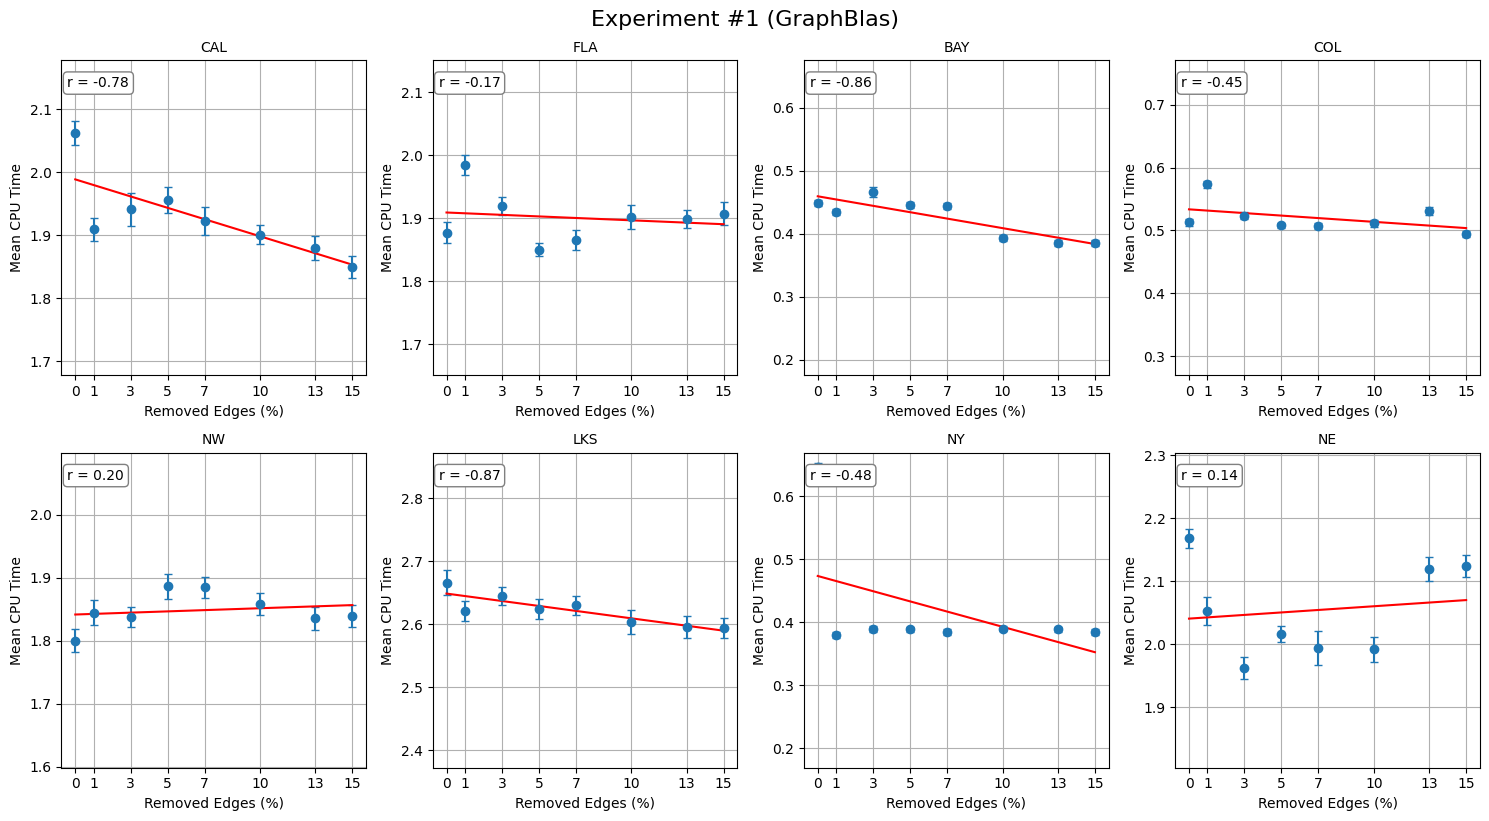

In [ ]:
r_values, p_values, names = plot_experiment1_results(
    experiment1resultsGB, "Experiment #1 (GraphBlas)"
)

In [180]:
# Bonferroni correction
# α (significance level) = 0.05, a 5% chance of a Type I error (rejecting H0 when it is actually true)

rejected, pvals_corrected, _, _ = multipletests(
    p_values, alpha=0.05, method="bonferroni"
)

df = pd.DataFrame(
    zip(names, r_values, p_values, pvals_corrected, rejected),
    columns=["Graph", "r", "p", "corrected p", "reject H0"],
)

# p_value -- number describing the likelihood of obtaining the observed data under the null hypothesis of a statistical test
# (Smaller p-value means stronger evidence in favor of the alternative hypothesis)
# (Decision rule: p < alpha => Reject H0)

# corrected p-value (Bonferroni) -- min(1, p * n), reduces false positives across tests
# (Decision rule: p_corrected < alpha => Reject H0)

# r_value (Pearson's correlation coefficient) -- strength and direction of a linear relationship between two variables
# - r > 0: positive correlation (X increases -> Y increases)
# - r < 0: negative correlation (X increases → Y decreases)

df

,Graph,r,p,corrected p,reject H0
0,CAL,-0.782567,0.021690,0.173524,False
1,FLA,-0.166988,0.692670,1.000000,False
2,BAY,-0.861912,0.005920,0.047359,True
3,COL,-0.454869,0.257462,1.000000,False
4,NW,0.195723,0.642283,1.000000,False
5,LKS,-0.868481,0.005141,0.041128,True
6,NY,-0.484526,0.223687,1.000000,False
7,NE,0.144117,0.733499,1.000000,False


# Эксперимент 2

In [ ]:
@dataclass
class Experiment2Data:
    graph_distribution: str
    mean: float
    std_dev: float
    confidence_interval: float


@dataclass
class Experiment2GraphData:
    experiment: List[Experiment2Data]


def parse_experiment2_results(file: Path) -> Dict[str, Experiment2GraphData]:
    graphs: Dict[str, Experiment2GraphData] = {}

    with file.open() as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        if lines[i].startswith("Run experiment for:"):
            graph_line = lines[i].split(":", 1)[1].strip()

            if graph_line.endswith(".gr"):
                graph_line = graph_line[:-3]

            base, _, suffix = graph_line.partition(".dist_")
            graph_distribution = suffix if suffix else "original"

            mean = float(re.search(r"([\d.]+)", lines[i + 1]).group(1))
            std_dev = float(re.search(r"([\d.]+)", lines[i + 2]).group(1))
            ci = float(re.search(r"±([\d.]+)", lines[i + 3]).group(1))

            data = Experiment2Data(
                graph_distribution=graph_distribution,
                mean=mean,
                std_dev=std_dev,
                confidence_interval=ci,
            )

            if base not in graphs:
                graphs[base] = Experiment2GraphData(
                    nodes_count=0, edges_count=0, experiment=[]
                )
            graphs[base].experiment.append(data)

            i += 4
        else:
            i += 1

    for graph_data in graphs.values():
        graph_data.experiment.sort(key=lambda e: e.graph_distribution)

    return graphs

In [ ]:
def plot_experiment2_results(
    experiment_results: Dict[str, Experiment2GraphData], experiment_name: str
):
    num_graphs = len(experiment_results)
    cols = 4
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()

    sorted_graphs = sorted(experiment_results.items(), key=lambda g: g[1].nodes_count)

    for idx, (name, graph_data) in enumerate(sorted_graphs):
        ax = axes[idx]

        x = [d.graph_distribution[:3] for d in graph_data.experiment]
        y = [d.mean for d in graph_data.experiment]
        yerr = [d.confidence_interval for d in graph_data.experiment]

        ax.bar(x, y, yerr=yerr, capsize=3, color="tab:blue")
        ax.set_title(name, fontsize=8)
        ax.set_xlabel("Weights Distribution")
        ax.set_ylabel("Mean Time")
        ax.grid(True)

    for j in range(len(sorted_graphs), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(experiment_name, fontsize=16, y=1.02)
    plt.show()

In [217]:
def anova(experiment_results: Dict[str, Experiment2GraphData]):
    distribution_data = defaultdict(list)
    
    for _, graph_data in experiment_results.items():
        for exp in graph_data.experiment:
            distribution_data[exp.graph_distribution].append(exp.mean)
    
    groups = list(distribution_data.values())
    
    f_stat, p_value = f_oneway(*groups)
    
    return f_stat, p_value

## GraphBlas

In [208]:
experiment2resultsGB = parse_experiment2_results(Path("../GraphBlas/results2.txt"))

experiment2resultsGB

{'CAL': Experiment2GraphData(nodes_count=0, edges_count=0, experiment=[Experiment2Data(graph_distribution='exp', mean=1.940093, std_dev=0.120497, confidence_interval=0.023617), Experiment2Data(graph_distribution='lognorm', mean=1.980105, std_dev=0.106147, confidence_interval=0.020805), Experiment2Data(graph_distribution='original', mean=2.061985, std_dev=0.148546, confidence_interval=0.029115), Experiment2Data(graph_distribution='uni', mean=2.073435, std_dev=0.121331, confidence_interval=0.023781)]),
 'FLA': Experiment2GraphData(nodes_count=0, edges_count=0, experiment=[Experiment2Data(graph_distribution='exp', mean=1.905852, std_dev=0.17489, confidence_interval=0.034278), Experiment2Data(graph_distribution='lognorm', mean=1.934879, std_dev=0.168883, confidence_interval=0.033101), Experiment2Data(graph_distribution='original', mean=1.877159, std_dev=0.235484, confidence_interval=0.046155), Experiment2Data(graph_distribution='uni', mean=1.877537, std_dev=0.172853, confidence_interval=0.

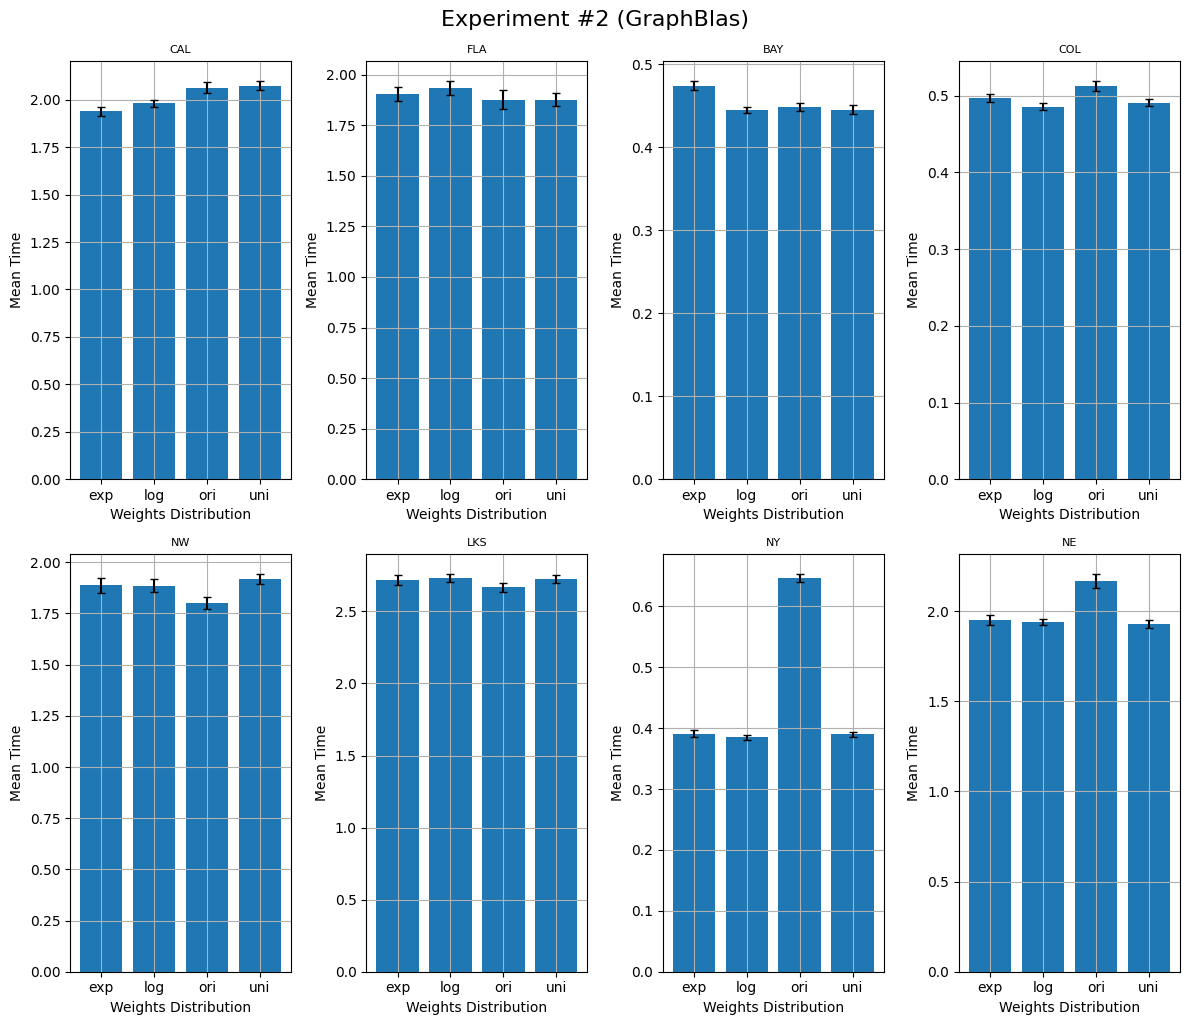

([1.940093,
  1.905852,
  0.474481,
  0.496674,
  1.887701,
  2.718029,
  0.391173,
  1.951841],
 [1.980105,
  1.934879,
  0.445229,
  0.485786,
  1.885458,
  2.732643,
  0.385003,
  1.94001],
 [2.061985,
  1.877159,
  0.448784,
  0.512797,
  1.800394,
  2.666081,
  0.646493,
  2.168214],
 [2.073435,
  1.877537,
  0.445607,
  0.490991,
  1.918265,
  2.722379,
  0.389878,
  1.927702])

In [200]:
plot_experiment2_results(experiment2resultsGB, "Experiment #2 (GraphBlas)")

In [223]:
f_stat, p_values = anova(experiment2resultsGB)

p_values

np.float64(0.9993481208050956)